In [1]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2hsv
from skimage.filters import threshold_sauvola
from skimage.segmentation import mark_boundaries
from skimage.feature import graycomatrix, graycoprops
import rasterio
import glob
import matplotlib.pyplot as plt

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config('base')

14-Nov-23 11:14:08 - INFO - Starting 'load_config'.
14-Nov-23 11:14:08 - INFO - Finished 'load_config' in 0.0138 secs.


In [3]:
def load_cropped_tifs(path):
    return glob.glob(f'{path}*.tif')

def load_raster(image_path):
    with rasterio.open(image_path) as src:
        # Read the data and transpose the dimensions
        raster_data = src.read().transpose(1, 2, 0)
    return raster_data


def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    logger.info(f'Normalized image shape: {normalized_image.shape}')
    return normalized_image

def process_rgb_image(image: np.ndarray) -> np.ndarray:
    """
    Extracts the RGB channels from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The RGB image.
    """
    # Add your RGB processing logic here
    img_rgb = image[:, :, :3]
    logger.info(f'RGB image shape: {img_rgb.shape}')
    return img_rgb

In [4]:
cropped_fns_rgb = load_cropped_tifs(conf.data.path_pri_rgb)
raster_img = load_raster(cropped_fns_rgb[0])
logger.info(f'Raster data shape: {raster_img.shape}')
rgb_img = process_rgb_image(raster_img)
rgb_norm_img = normalize_image(rgb_img)

14-Nov-23 11:14:08 - INFO - Raster data shape: (37, 37, 4)
14-Nov-23 11:14:08 - INFO - RGB image shape: (37, 37, 3)
14-Nov-23 11:14:08 - INFO - Normalized image shape: (37, 37, 3)


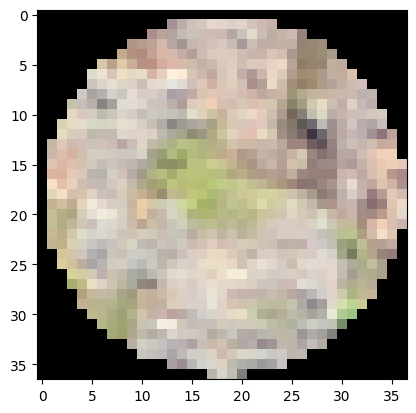

In [5]:
plt.imshow(rgb_norm_img)
plt.show()

In [8]:
def extract_color_histogram(image: np.ndarray, bins: int = 32) -> np.ndarray:
    """
    Extracts the color histogram from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.
    - bins (int): The number of bins for the histogram.

    Returns:
    - numpy.ndarray: The color histogram.
    """
    # Compute the histogram of the RGB channels separately
    rhist = cv2.calcHist([image], [0], None, [bins], [0, 256])
    ghist = cv2.calcHist([image], [1], None, [bins], [0, 256])
    bhist = cv2.calcHist([image], [2], None, [bins], [0, 256])

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([rhist, ghist, bhist])

    # Normalize the histogram
    cv2.normalize(hist_features, hist_features)

    return hist_features


def extract_texture_features(image: np.ndarray) -> np.ndarray:
    """
    Extracts texture features from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The texture features.
    """
    # Convert the image to uint8
    image_uint8 = (image * 255).astype(np.uint8)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    # Compute the GLCM of the grayscale image
    glcm = graycomatrix(gray_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    # Compute texture features from the GLCM
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    # Concatenate the texture features into a single feature vector
    texture_features = np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])

    return texture_features


def extract_shape_features(image: np.ndarray) -> np.ndarray:
    """
    Extracts shape features from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The shape features.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize the image to have a depth of 8 bits
    gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    

    # Initialize the SIFT feature extractor
    sift = cv2.xfeatures2d.SIFT_create()

    # Compute the SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    return descriptors

In [9]:
hist_features = extract_color_histogram(rgb_norm_img, bins=32)
texture_features = extract_texture_features(rgb_norm_img)
shape_features = extract_shape_features(rgb_norm_img)

In [10]:
hist_features

array([[0.57735026],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.57735026],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [11]:
texture_features

array([[1.88452628e+03, 2.75813580e+03, 1.97160886e+03, 2.81831327e+03],
       [1.93175676e+01, 2.56774691e+01, 2.05683183e+01, 2.67546296e+01],
       [2.73240132e-01, 2.38662572e-01, 2.65248877e-01, 2.28537505e-01],
       [2.15712522e-01, 1.85785421e-01, 2.13440432e-01, 1.85711700e-01],
       [8.60349262e-01, 7.84226928e-01, 8.53434480e-01, 7.79300270e-01]])

In [12]:
shape_features

array([[  2.,   0.,   0., ...,   0.,   2.,  19.],
       [  0.,   0.,   0., ...,   2.,   4.,   1.],
       [  5.,  27.,  76., ...,   9.,   7.,   1.],
       ...,
       [119.,   3.,   3., ...,   0.,   0.,   1.],
       [ 18.,   0.,   0., ...,   2.,   1.,   3.],
       [  0.,   0.,   0., ...,  12.,   8.,  22.]], dtype=float32)